In [1]:
#basic essential libraries
import pandas as pd
import numpy as np
import scipy as sp
import sklearn as sk
import random
import string
#statsmodel
import statsmodels.api as sm
from scipy import stats
#to ignore warning messages
import warnings
warnings.filterwarnings('ignore')
from subprocess import check_output

In [2]:
#Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

#set visual parameters
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 10,6

In [167]:
PATH = "C:/Users/kpunyakoti/Desktop/Future/Flix/Data/traintest/"
PATH2 = "C:/Users/kpunyakoti/Desktop/Future/Flix/Data/"

In [168]:
train = pd.read_csv(f'{PATH}train.csv')
test = pd.read_csv(f'{PATH}test.csv')
dp = pd.read_csv(f'{PATH2}datapoint.csv')

In [169]:
test.tickets = np.nan

In [170]:
dp.dtypes

country_1     int64
channel_id    int64
rowcount      int64
dtype: object

In [171]:
cols_str = ['country_1', 'channel_id']
for x in cols_str:
    train[x] = train[x].astype(str)
    test[x] = test[x].astype(str)
    dp[x] = dp[x].astype(str)

In [172]:
train['cc'] = train.country_1+'_'+train.channel_id
test['cc'] = test.country_1+'_'+test.channel_id
dp['cc'] = dp.country_1+'_'+dp.channel_id

In [173]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [174]:
dp.head()

,country_1,channel_id,rowcount,cc
0,20,23,3,20_23
1,20,26,52,20_26
2,20,28,411,20_28
3,20,29,25,20_29
4,20,31,123,20_31


In [175]:
cc_minor = dp.loc[dp['rowcount']<25, 'cc']

In [176]:
for i in cc_minor.values:
    test.loc[test['cc'] == i, 'tickets'] = 0

In [177]:
cc_major = dp.loc[~dp.cc.isin(cc_minor.values), 'cc']

#### Run from here safely

In [191]:
new_train = train.loc[train.cc.isin(cc_major.values)]
new_test = test.loc[test.cc.isin(cc_major.values)]

In [159]:
def transform(df):
    df.set_index('date', inplace=True)
    return df


## From Kernel

In [192]:
new_train['is_train'] = True
new_test['is_train'] = False
df = new_train.append(new_test, ignore_index=True, sort=True)

df['mon'] = df['date'].dt.month
df['wk'] = df['date'].dt.week

df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.dayofweek
df['dayofyear'] = df['date'].dt.dayofyear 

df_train = df.groupby('is_train').get_group(True).copy()
df_test = df.groupby('is_train').get_group(False).copy()

In [193]:
df_test.head()

,cc,channel_id,country_1,date,is_train,tickets,mon,wk,day,weekday,dayofyear
75555,1_28,28,1,2018-01-01,False,NaN,1,1,1,0,1
75556,1_28,28,1,2018-01-02,False,NaN,1,1,2,1,2
75557,1_28,28,1,2018-01-03,False,NaN,1,1,3,2,3
75558,1_28,28,1,2018-01-04,False,NaN,1,1,4,3,4
75559,1_28,28,1,2018-01-05,False,NaN,1,1,5,4,5


Text(0.5,1,'Store 10 Sales Distribution')

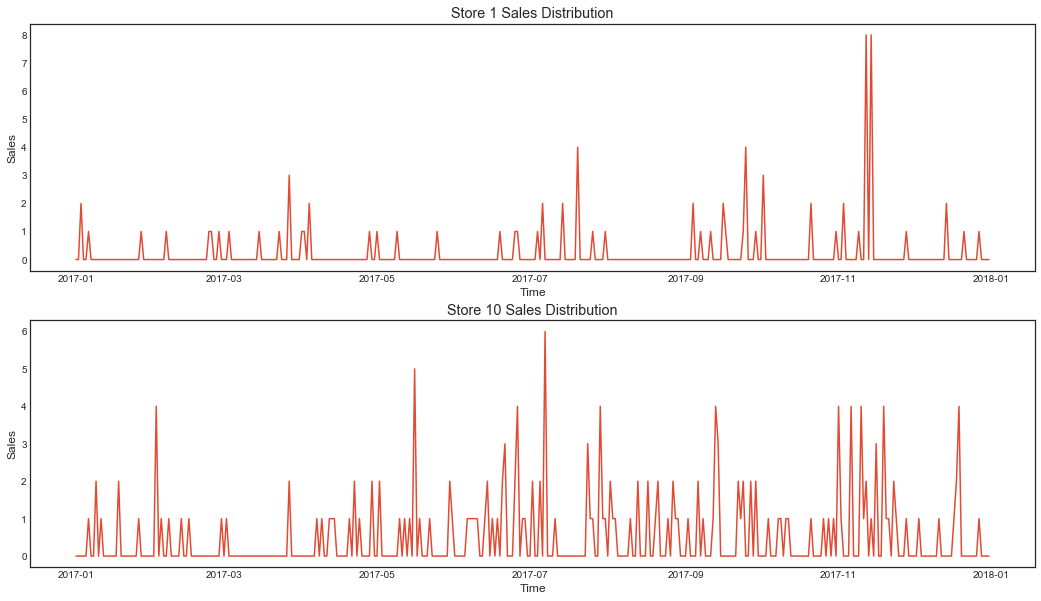

In [194]:
import matplotlib.pyplot as plt
cc_1 = df_train.loc[(df_train["cc"]=='20_26'), ['date',"tickets"]]
cc_10 = df_train.loc[(df_train["cc"]== '20_31'), ['date',"tickets"]]
f = plt.figure(figsize=(18,10))
ax1 = f.add_subplot(211)
ax1.plot(cc_1['date'], cc_1['tickets'], '-')
ax1.set_xlabel('Time')
ax1.set_ylabel('Sales')
ax1.set_title('Store 1 Sales Distribution')

ax2 = f.add_subplot(212)
ax2.plot(cc_10['date'],cc_10['tickets'], '-')
ax2.set_xlabel('Time')
ax2.set_ylabel('Sales')
ax2.set_title('Store 10 Sales Distribution')

In [195]:
df_train = df_train.sort_values(['date'],ascending = False)
train_total = df_train.copy()

tr = train_total.loc[train_total.date < '2017-11-19'] 
valid = train_total.loc[train_total.date >= '2017-11-19']

tr = tr[tr.tickets>0]
valid = valid[valid.tickets>0]

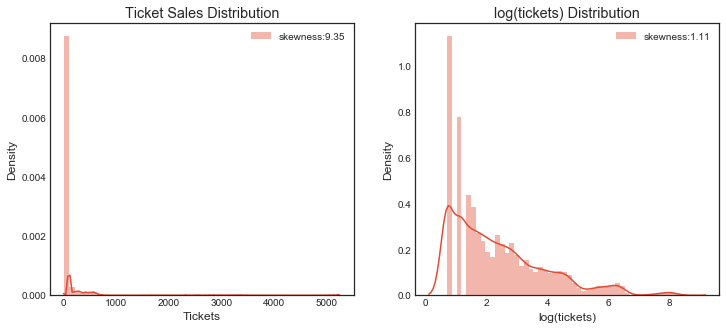

In [196]:
import seaborn as sns
import matplotlib.pyplot as plt

# check distribution of sales in train set
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

g1 = sns.distplot(tr['tickets'],hist = True,label='skewness:{:.2f}'.format(tr['tickets'].skew()),ax = ax1)
g1.legend()
g1.set(xlabel = 'Tickets', ylabel = 'Density', title = 'Ticket Sales Distribution')
g2 = sns.distplot(np.log1p(tr['tickets']),hist = True,label='skewness:{:.2f}'.format(np.log1p(tr['tickets']).skew()),ax=ax2)
g2.legend()
g2.set(xlabel = 'log(tickets)',ylabel = 'Density', title = 'log(tickets) Distribution')
plt.show()


In [197]:
features = ['country_1', 'channel_id', 'tickets', 'mon', 'wk', 'day', 'weekday', 'dayofyear']

tr = tr[features]
valid = valid[features]

In [198]:
#valid.sort_index(inplace = True)
#train.sort_index(inplace = True)
#train_total.sort_index(inplace = True)

# split x and y
x_train, y_train = tr.drop(columns = ['tickets']), np.log1p(tr['tickets'])
x_valid, y_valid = valid.drop(columns = ['tickets']), np.log1p(valid['tickets'])
#x_train_total, y_train_total = train_total.drop(columns = ['Sales']), np.log1p(train_total['Sales'])

In [199]:
# define eval metrics
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

In [200]:
# try random forest
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(n_estimators = 15)
clf.fit(x_train, y_train)
# validation
y_pred = clf.predict(x_valid)
error = rmspe(np.expm1(y_valid), np.expm1(y_pred))
print('RMSPE: {:.4f}'.format(error))

RMSPE: 0.9848


In [201]:
features2 = ['country_1', 'channel_id', 'mon', 'wk', 'day', 'weekday', 'dayofyear']
df_test2 = df_test[features2]

In [202]:
test_preds = clf.predict(df_test2)

In [224]:
df_test['tickets_y'] = np.round(np.expm1(test_preds))

In [226]:
test.shape

(46284, 5)

In [229]:
df_test.shape

(11799, 11)

In [235]:
final_test.shape

(46284, 4)

In [230]:
final_test = test.merge(df_test, how='left')

In [232]:
final_test.head()

,date,country_1,channel_id,tickets,cc,is_train,mon,wk,day,weekday,dayofyear,tickets_y
0,2018-01-01,1,1,0.0,1_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-02,1,1,0.0,1_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-03,1,1,0.0,1_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-04,1,1,0.0,1_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-05,1,1,0.0,1_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [233]:
feats = ['date', 'country_1', 'channel_id', 'tickets', 'tickets_y']
final_test = final_test[feats]

In [234]:
final_test.fillna(0, inplace=True)
final_test['tickets'] = final_test.tickets+final_test.tickets_y
final_test.drop('tickets_y', axis=1, inplace=True)

In [236]:
final_test.to_csv(f'{PATH}final_test.csv')

Text(0.5,1,'Feature Importance')

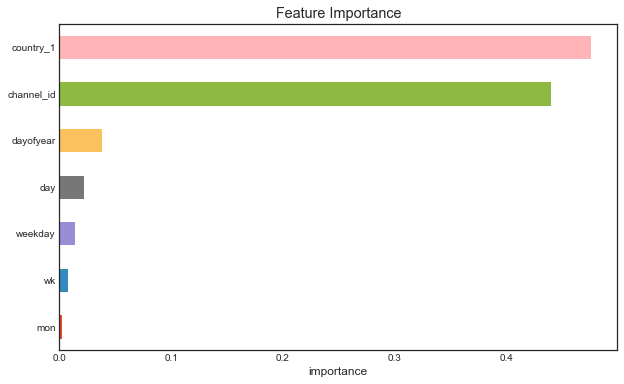

In [132]:
feat_importances = pd.Series(clf.feature_importances_, index=x_train.columns)
feat_importances.nlargest(10).sort_values(ascending = True).plot(kind='barh')
plt.xlabel('importance')
plt.title('Feature Importance')

In [238]:
int_col = ['country_1', 'channel_id']
for i in int_col:
    df_test2[i] = df_test2[i].astype(int)
    x_train[i] = x_train[i].astype(int)
    x_valid[i] = x_valid[i].astype(int)

In [239]:
import xgboost as xgb

params = {"objective": "reg:linear", # for linear regression
          "booster" : "gbtree",   # use tree based models 
          "eta": 0.03,   # learning rate
          "max_depth": 10,    # maximum depth of a tree
          "subsample": 0.9,    # Subsample ratio of the training instances
          "colsample_bytree": 0.7,   # Subsample ratio of columns when constructing each tree
          "silent": 1,   # silent mode
          "seed": 10   # Random number seed
          }
num_boost_round = 4000

dtrain = xgb.DMatrix(x_train, y_train)
dvalid = xgb.DMatrix(x_valid, y_valid)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
# train the xgboost model
model = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
  early_stopping_rounds= 100, feval=rmspe_xg, verbose_eval=True)


[0]	train-rmse:2.33369	eval-rmse:2.32389	train-rmspe:0.81639	eval-rmspe:0.812558
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:2.29243	eval-rmse:2.28169	train-rmspe:0.798584	eval-rmspe:0.793883
[2]	train-rmse:2.24579	eval-rmse:2.23552	train-rmspe:0.784727	eval-rmspe:0.780504
[3]	train-rmse:2.2014	eval-rmse:2.19228	train-rmspe:0.771491	eval-rmspe:0.766971
[4]	train-rmse:2.15884	eval-rmse:2.15171	train-rmspe:0.760211	eval-rmspe:0.7556
[5]	train-rmse:2.1239	eval-rmse:2.11788	train-rmspe:0.749614	eval-rmspe:0.745395
[6]	train-rmse:2.08446	eval-rmse:2.08176	train-rmspe:0.74291	eval-rmspe:0.739629
[7]	train-rmse:2.04439	eval-rmse:2.04218	train-rmspe:0.735676	eval-rmspe:0.732805
[8]	train-rmse:2.01368	eval-rmse:2.01163	train-rmspe:0.732202	eval-rmspe:0.729768
[9]	train-rmse:1.95687	eval-rmse:1.956	train-rmspe:0.727283	eval-rmspe:0.725405
[10]	train-rmse:1.92853	eval-rmse:1.92726	

[98]	train-rmse:0.618058	eval-rmse:0.687338	train-rmspe:1.06289	eval-rmspe:1.25
[99]	train-rmse:0.61566	eval-rmse:0.685421	train-rmspe:1.06569	eval-rmspe:1.25661
[100]	train-rmse:0.613387	eval-rmse:0.683478	train-rmspe:1.06852	eval-rmspe:1.26412
[101]	train-rmse:0.611274	eval-rmse:0.682597	train-rmspe:1.07172	eval-rmspe:1.26731
[102]	train-rmse:0.600462	eval-rmse:0.673041	train-rmspe:1.05685	eval-rmspe:1.25585
[103]	train-rmse:0.59853	eval-rmse:0.671833	train-rmspe:1.05984	eval-rmspe:1.26163
[104]	train-rmse:0.596688	eval-rmse:0.670478	train-rmspe:1.06272	eval-rmspe:1.26733
[105]	train-rmse:0.586631	eval-rmse:0.661052	train-rmspe:1.04873	eval-rmspe:1.25696
[106]	train-rmse:0.576924	eval-rmse:0.652179	train-rmspe:1.03517	eval-rmspe:1.24517
[107]	train-rmse:0.575299	eval-rmse:0.650863	train-rmspe:1.03771	eval-rmspe:1.25041
[108]	train-rmse:0.574994	eval-rmse:0.650786	train-rmspe:1.04096	eval-rmspe:1.2519
[109]	train-rmse:0.573506	eval-rmse:0.650233	train-rmspe:1.04353	eval-rmspe:1.25483


In [243]:
# validation
num_boost_round2 = 12
model2 = xgb.train(params, dtrain, num_boost_round2, evals=watchlist, \
  early_stopping_rounds= 100, feval=rmspe_xg, verbose_eval=True)

[0]	train-rmse:2.33369	eval-rmse:2.32389	train-rmspe:0.81639	eval-rmspe:0.812558
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:2.29243	eval-rmse:2.28169	train-rmspe:0.798584	eval-rmspe:0.793883
[2]	train-rmse:2.24579	eval-rmse:2.23552	train-rmspe:0.784727	eval-rmspe:0.780504
[3]	train-rmse:2.2014	eval-rmse:2.19228	train-rmspe:0.771491	eval-rmspe:0.766971
[4]	train-rmse:2.15884	eval-rmse:2.15171	train-rmspe:0.760211	eval-rmspe:0.7556
[5]	train-rmse:2.1239	eval-rmse:2.11788	train-rmspe:0.749614	eval-rmspe:0.745395
[6]	train-rmse:2.08446	eval-rmse:2.08176	train-rmspe:0.74291	eval-rmspe:0.739629
[7]	train-rmse:2.04439	eval-rmse:2.04218	train-rmspe:0.735676	eval-rmspe:0.732805
[8]	train-rmse:2.01368	eval-rmse:2.01163	train-rmspe:0.732202	eval-rmspe:0.729768
[9]	train-rmse:1.95687	eval-rmse:1.956	train-rmspe:0.727283	eval-rmspe:0.725405
[10]	train-rmse:1.92853	eval-rmse:1.92726	

In [244]:
y_pred2 = model2.predict(xgb.DMatrix(x_valid))
error = rmspe(np.expm1(y_valid), np.expm1(y_pred2))
print('RMSPE: {:.4f}'.format(error))

RMSPE: 0.7229


Best weight is 0.98, RMSPE is 0.7222


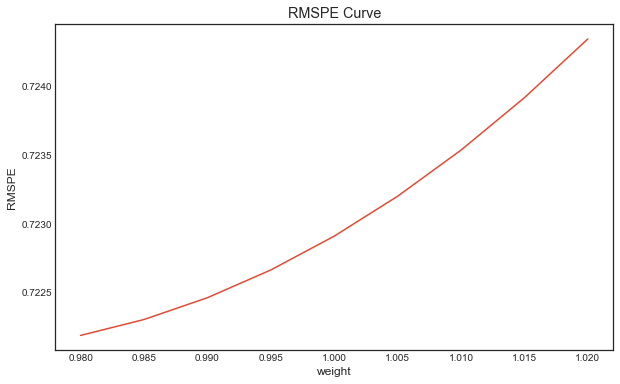

In [246]:
# rmspe correction on the whole
def correction():
    weights = np.arange(0.98, 1.02, 0.005)
    errors = []
    for w in weights:
        error = rmspe(np.expm1(y_valid), np.expm1(y_pred2*w))
        errors.append(error)
        
    # make line plot
    plt.plot(weights, errors)
    plt.xlabel('weight')
    plt.ylabel('RMSPE')
    plt.title('RMSPE Curve')
    # print min error
    idx = errors.index(min(errors))
    print('Best weight is {}, RMSPE is {:.4f}'.format(weights[idx], min(errors)))
    
correction()

In [247]:
dtest = xgb.DMatrix(df_test2)
# specify parameters via map
params = {"objective": "reg:linear", # for linear regression
          "booster" : "gbtree",   # use tree based models 
          "eta": 0.03,   # learning rate
          "max_depth": 10,    # maximum depth of a tree
          "subsample": 0.9,    # Subsample ratio of the training instances
          "colsample_bytree": 0.7,   # Subsample ratio of columns when constructing each tree
          "silent": 1,   # silent mode
          "seed": 10   # Random number seed
          }
num_round = 12
model3 = xgb.train(params, dtrain, num_round)
# make prediction
preds = model3.predict(dtest)

In [248]:
df_test['tickets_y2'] = np.round(np.expm1(preds))

In [250]:
final_test2 = test.merge(df_test, how='left')
feats2 = ['date', 'country_1', 'channel_id', 'tickets', 'tickets_y2']
final_test2 = final_test2[feats2]

In [251]:
final_test2.fillna(0, inplace=True)
final_test2['tickets'] = final_test2.tickets+final_test2.tickets_y2
final_test2.drop('tickets_y2', axis=1, inplace=True)

In [252]:
final_test2.to_csv(f'{PATH}final_test2.csv')